<a href="https://colab.research.google.com/github/paseyy/FitnessPose/blob/main/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# easy_ViTPose demo
Be sure to enable GPU runtime

In [1]:
!git clone https://github.com/JunkyByte/easy_ViTPose.git
!cd easy_ViTPose/ && pip install -r requirements.txt && pip install -e .
!pip install huggingface_hub

fatal: destination path 'easy_ViTPose' already exists and is not an empty directory.
Obtaining file:///content/easy_ViTPose
  Preparing metadata (setup.py) ... done
  Attempting uninstall: easy_ViTPose
    Found existing installation: easy_ViTPose 1.1
    Uninstalling easy_ViTPose-1.1:
      Successfully uninstalled easy_ViTPose-1.1
  Running setup.py develop for easy_ViTPose


# Restart the runtime (runtime -> restart runtime) to update installed packages versions

# Download the models

In [2]:
#@title Choose model and run this cell

MODEL_SIZE = 'b'  #@param ['s', 'b', 'l', 'h']
YOLO_SIZE = 's'  #@param ['s', 'n']
DATASET = 'wholebody'  #@param ['coco_25', 'coco', 'wholebody', 'mpii', 'aic', 'ap10k', 'apt36k']
ext = '.pth'
ext_yolo = '.pt'

In [3]:
import os
from huggingface_hub import hf_hub_download
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Run inference

In [4]:
# If you get an error from PIL restart environment and rerun this cell to update packages version
from easy_ViTPose import VitInference
model = VitInference(model_path, yolo_path, MODEL_SIZE,
                     dataset=DATASET, yolo_size=320, is_video=False)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


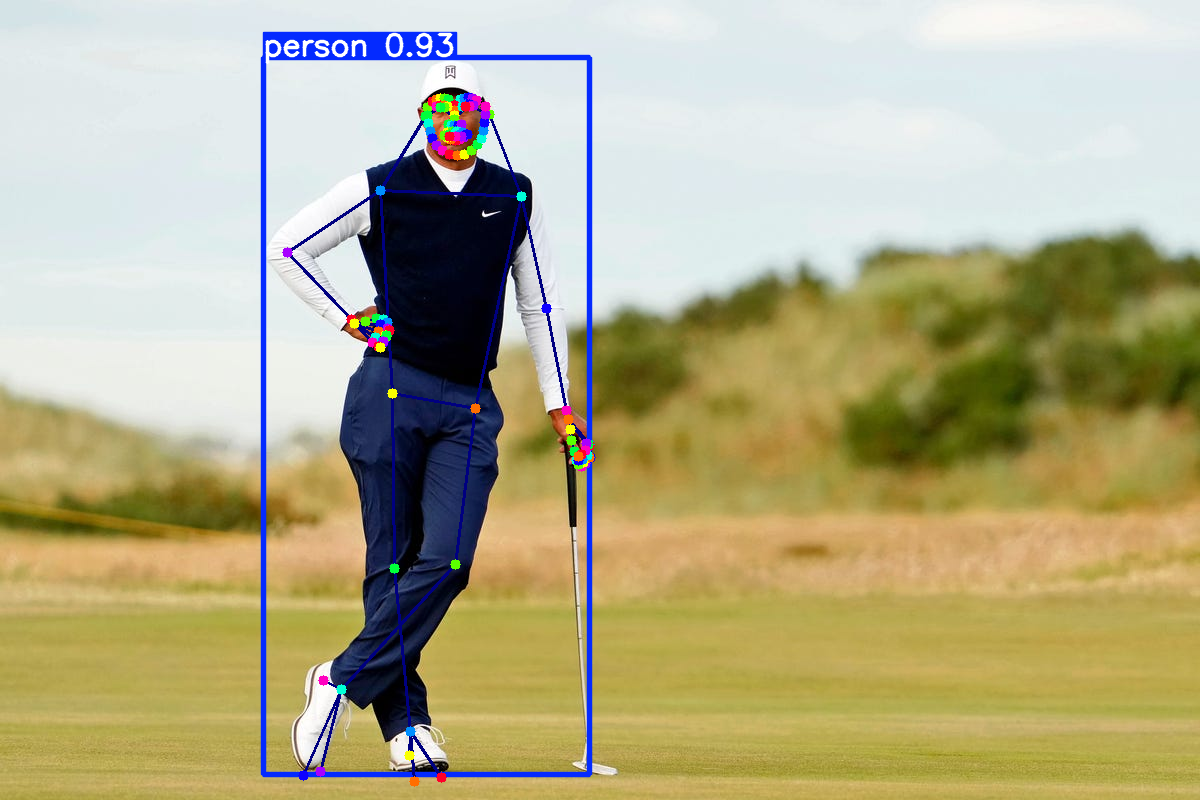

In [5]:
# Run inference on example image
import numpy as np
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

# Load image and run inference
url = 'https://i.ibb.co/gVQpNqF/imggolf.jpg'
img = np.array(Image.open(BytesIO(urlopen(url).read())), dtype=np.uint8)

frame_keypoints = model.inference(img)
img = model.draw(show_yolo=True)

from google.colab.patches import cv2_imshow
cv2_imshow(img[..., ::-1])

Saving 12580_Ruysch_crop.jpg to 12580_Ruysch_crop.jpg


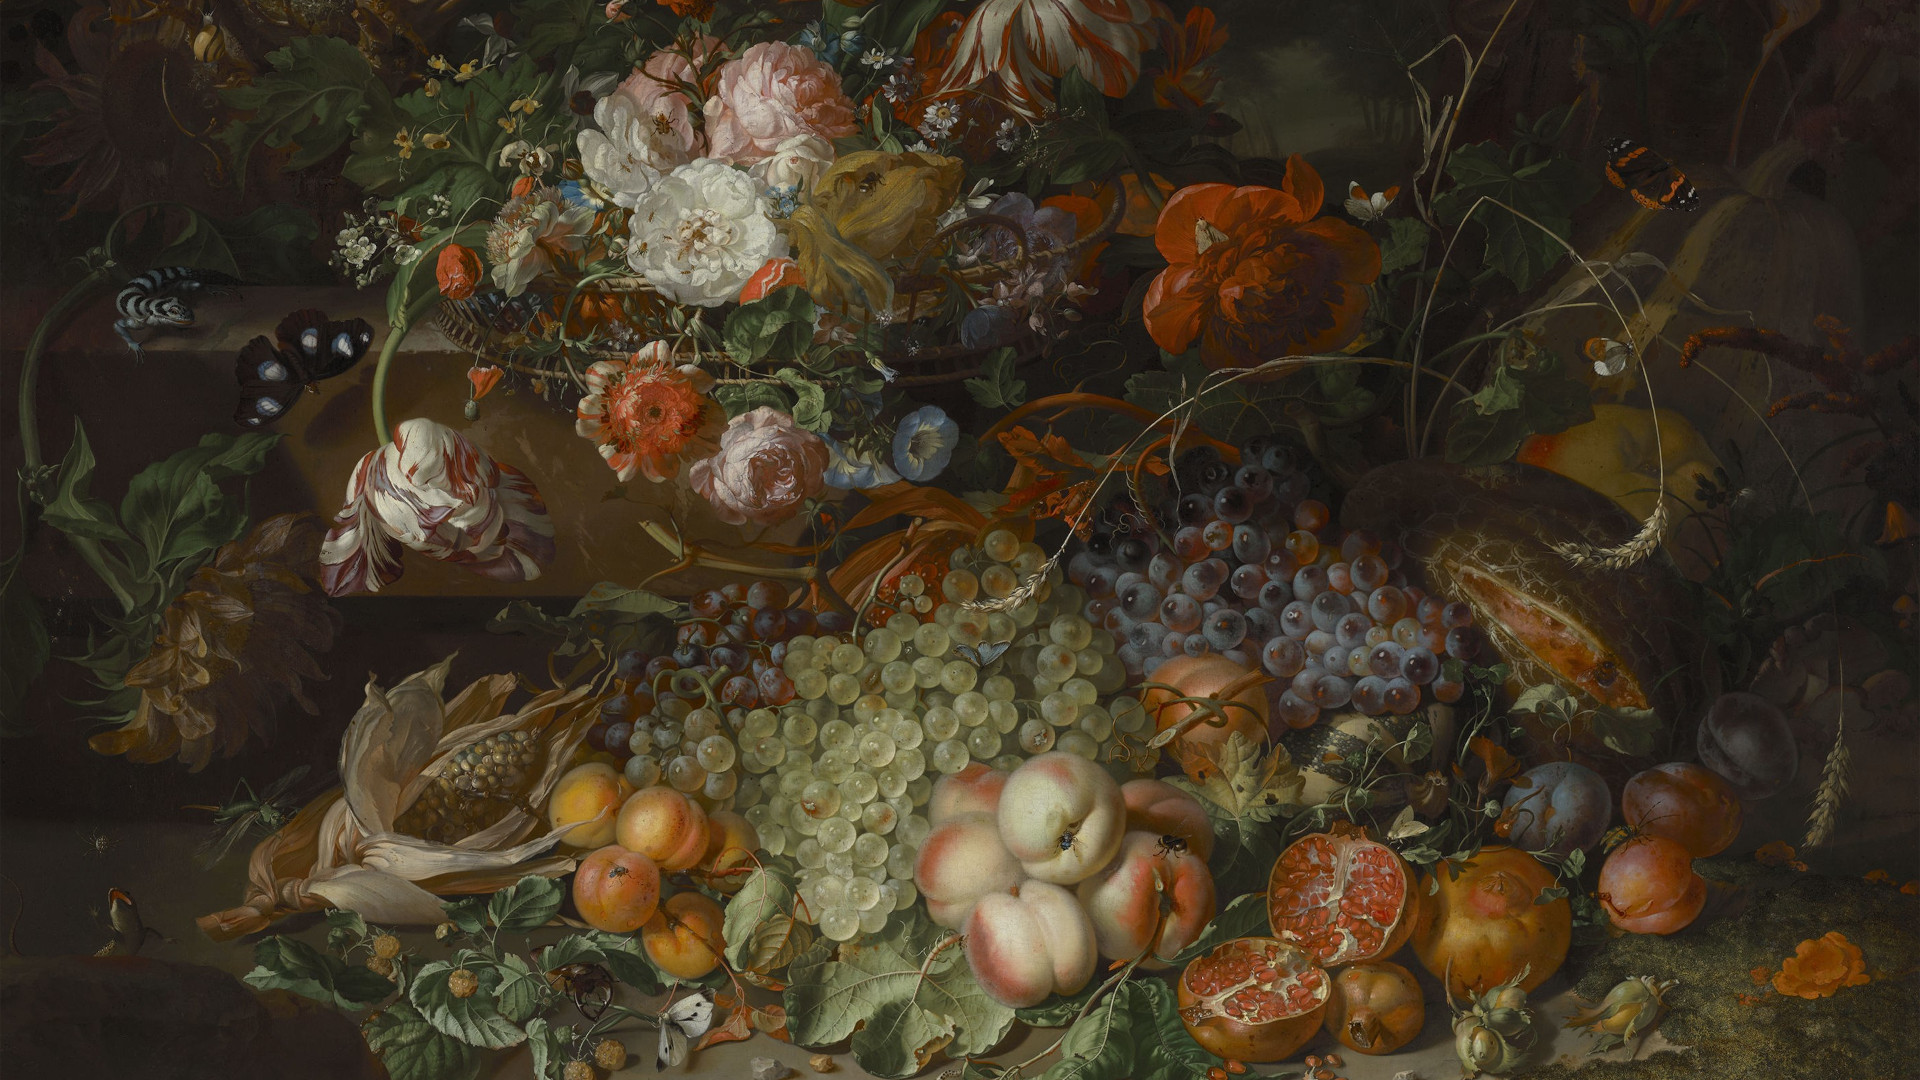

In [6]:
#@title Custom image
from google.colab import files
import numpy as np
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
from vit_utils.visualization import draw_points_and_skeleton, joints_dict

img = np.array(Image.open(list(files.upload().keys())[0]), dtype=np.uint8)

frame_keypoints = model.inference(img)
img = model.draw(show_yolo=True)

from google.colab.patches import cv2_imshow
cv2_imshow(img[..., ::-1])

In [7]:

def inference(args):
    try:
        import onnxruntime  # noqa: F401
        has_onnx = True
    except ModuleNotFoundError:
        has_onnx = False

    use_mps = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
    use_cuda = torch.cuda.is_available()

    # Load Yolo
    yolo = args.yolo
    if yolo is None:
        yolo = 'easy_ViTPose/' + ('yolov8s' + ('.onnx' if has_onnx and not (use_mps or use_cuda) else '.pt'))
    input_path = args.input

    # Load the image / video reader
    try:  # Check if is webcam
        int(input_path)
        is_video = True
    except ValueError:
        assert os.path.isfile(input_path), 'The input file does not exist'
        is_video = input_path[input_path.rfind('.') + 1:].lower() in ['avi', 'mp4', 'mov']

    ext = '.mp4' if is_video else '.png'
    assert not (args.save_img or args.save_json) or args.output_path, \
        'Specify an output path if using save-img or save-json flags'
    output_path = "out/"

    # Output path
    file_output_path = os.path.join(output_path, os.path.basename(input_path))
    os.makedirs(file_output_path, exist_ok=True)
    og_ext = input_path[input_path.rfind('.'):]
    save_name_img = os.path.basename(input_path).replace(og_ext, f"_result{ext}")
    save_name_json = os.path.basename(input_path).replace(og_ext, "_result.json")
    output_path_img = os.path.join(file_output_path, save_name_img)
    output_path_json = os.path.join(file_output_path, save_name_json)


    wait = 0
    total_frames = 1
    if is_video:
        reader = VideoReader(input_path, args.rotate)
        cap = cv2.VideoCapture(input_path)  # type: ignore
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        wait = 15
        if args.save_img:
            cap = cv2.VideoCapture(input_path)  # type: ignore
            fps = cap.get(cv2.CAP_PROP_FPS)
            ret, frame = cap.read()
            cap.release()
            assert ret
            assert fps > 0
            output_size = frame.shape[:2][::-1]

            # Check if we have X264 otherwise use default MJPG
            try:
                temp_video = cv2.VideoWriter('/tmp/checkcodec.mp4',
                                             cv2.VideoWriter_fourcc(*'h264'), 30, (32, 32))
                opened = temp_video.isOpened()
            except Exception:
                opened = False
            codec = 'h264' if opened else 'MJPG'
            out_writer = cv2.VideoWriter(output_path_img,
                                         cv2.VideoWriter_fourcc(*codec),  # More efficient codec
                                         fps, output_size)  # type: ignore
    else:
        reader = [np.array(Image.open(input_path).rotate(args.rotate))]  # type: ignore

    # Initialize model
    model = VitInference(args.model, yolo, args.model_name,
                         args.det_class, args.dataset,
                         args.yolo_size, is_video=is_video,
                         single_pose=args.single_pose,
                         yolo_step=args.yolo_step)  # type: ignore
    print(f">>> Model loaded: {args.model}")

    print(f'>>> Running inference on {input_path}')
    keypoints = []
    fps = []
    tot_time = 0.
    for (ith, img) in tqdm.tqdm(enumerate(reader), total=total_frames):
        t0 = time.time()

        # Run inference
        frame_keypoints = model.inference(img)
        keypoints.append(frame_keypoints)

        delta = time.time() - t0
        tot_time += delta
        fps.append(delta)

        # Draw the poses and save the output img
        if args.show or args.save_img:
            # Draw result and transform to BGR
            img = model.draw(args.show_yolo, args.show_raw_yolo, args.conf_threshold)[..., ::-1]

            if args.save_img:
                # TODO: If exists add (1), (2), ...
                if is_video:
                    out_writer.write(img)
                else:
                    print('>>> Saving output image')
                    cv2.imwrite(output_path_img, img)

            if args.show:
                cv2.imshow('preview', img)
                cv2.waitKey(wait)

    if is_video:
        tot_poses = sum(len(k) for k in keypoints)
        print(f'>>> Mean inference FPS: {1 / np.mean(fps):.2f}')
        print(f'>>> Total poses predicted: {tot_poses} mean per frame: '
              f'{(tot_poses / (ith + 1)):.2f}')
        print(f'>>> Mean FPS per pose: {(tot_poses / tot_time):.2f}')

    if args.save_json:
        print('>>> Saving output json')
        with open(output_path_json, 'w') as f:
            out = {'keypoints': keypoints,
                   'skeleton': joints_dict()[model.dataset]['keypoints']}
            json.dump(out, f, cls=NumpyEncoder)

    if is_video and args.save_img:
        out_writer.release()
    cv2.destroyAllWindows()

In [8]:
# prompt: write some code that opens an uploaded video in.mp4, performs the pose estimation and saves the keypoints to out.json

# Run inference on uploaded video
# Upload a video file (e.g., named "in.mp4")
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]

# Create a video reader
import cv2
cap = cv2.VideoCapture(video_filename)

all_frame_keypoints = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform inference on the frame
    frame_keypoints = model.inference(frame)
    all_frame_keypoints.append(frame_keypoints)

cap.release()

# Save the keypoints to a JSON file
import json
with open('out.json', 'w') as f:
    json.dump(all_frame_keypoints, f)

print("Keypoints saved to out.json")

Saving 80809_4.mp4 to 80809_4.mp4


TypeError: Object of type ndarray is not JSON serializable